# Text Classification using Embeddings
In this workbook we will take textual data and attempt to make a prediction about the text.

Specifically we will be tacking __Sentiment Analysis__ which is analysis to decide if text has a positive or negative Sentiment. However, we shouldn't get too hung-up on the positive/negative aspect of this classification, with suitable data we could easily use the ideas in this workbook to:
- Detect Irony in text
- Group text by topic
- Identify toxic comments post

We will in this workbook and the next two be using a standard dataset of IMDB Movie Reviews that have been hand classified as either Postive or Negative reviews.

# Importing some packages
We are using the Python programming language and a set of Machine Learning packages - Importing packages for use is a common task. For this workshop you don't really need to pay that much attention to this step (but you do need to execute the cell) since we are focusing on building models. However the following is a description of what this cell does that you can read if you are interested.

### Description of imports (Optional)
You don't need to worry about this code as this is not the focus on the workshop but if you are interested in what this next cell does, here is an explaination.

|Statement|Meaning|
|---|---|
|__import tensorflow as tf__ |Tensorflow (from Google) is our main machine learning library and we performs all of the various calculations for us and so hides much of the detailed complexity in Machine Learning. This _import_ statement makes the power of TensorFlow available to us and for convience we will refer to it as __tf__ |
|__from tensorflow import keras__ |Tensorflow is quite a low level machine learning library which, while powerful and flexible can be confusing so instead we use another higher level framework called Keras to make our machine learning models more readable and easier to build and test. This _import_ statement makes the Keras framework available to us.|
|__import numpy as np__ |Numpy is a Python library for scientific computing and is commonly used for machine learning. This _import_ statement makes the Keras framework available to us.|
|__import matplotlib.pyplot as plt__ |To visualise what is happening in our network we will use a set of graphs and MatPlotLib is the standard Python library for producing Graphs so we __import__ this to enable us to make pretty graphs.|
|__%matplotlib inline__| this is a Jupyter Notebook __magic__ commmand that tells the workbook to produce any graphs as part of the workbook and not as pop-up window.|

In [18]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)
%matplotlib inline

2.0.0-beta1


## Helper functions
The following cell contains a set of helper functions that makes our models a little clearer. We will not be going through these functions (since they require Python knowlege) so just make sure you have run this cell.

In [19]:
def printLossAndAccuracy(history):
  import matplotlib.pyplot as plt
  history_dict = history.history

  acc = history_dict['acc']
  val_acc = history_dict['val_acc']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  
  plt.show()

  plt.clf()   # clear figure

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()


  plt.show()

def predictStarRating(review, model, word_index):
      encoded_review = [encodeReview(review, word_index)]
      sequence = keras.preprocessing.sequence.pad_sequences(encoded_review,
                                                      value=word_index["<PAD>"],
                                                      padding='post',
                                                      maxlen=256)
      prediction = model.predict(sequence)
      if prediction >= 0.9:
          return "5 Stars"
      if prediction >= 0.7:
          return "4 Stars"
      if prediction >= 0.5:
          return "3 Stars"
      if prediction >= 0.3:
              return "2 Stars"
      return "1 Star"
      

def getWordIndex(corpus):
  word_index = corpus.get_word_index()

  # The first indices are reserved
  word_index = {k:(v+3) for k,v in word_index.items()}
  word_index["<PAD>"] = 0
  word_index["<START>"] = 1
  word_index["<UNK>"] = 2  # unknown
  word_index["<UNUSED>"] = 3

  reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])  

  return word_index, reverse_word_index

def decodeReview(text, reverse_word_index):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

def encodeReview(text, word_index):
  remove_words = ["!", "$", "%", "&", "*", ".", "?", "<", ">", ","]  
  for word in remove_words:
      text = text.replace(word, "")
  
  return [word_index[token] if token in word_index else 2 for token in text.lower().split(" ")]


# Load the Dataset
In this lesson we will be using a Standard Text Database called the IMDB Reviews Database. This contains a large number of reviews from the Internet Movie Database site about a range of films.

This is a standard dataset used in Machine Learning for Natural Language Processing and _Keras_ provides us with easy access to this data. Each Movie Review has a Sentiment attached either Positive or Negative. We want to train a Classifer to estimate whether it things a provide review is Positive or Negative or some where in between.

Similar to when we used the MNIST datasets, Keras provides an easy means to load the data and has pre-tokenised the data.

In [20]:
# Load the data
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))
# A dictionary mapping words to an integer index
word_index, reverse_word_index = getWordIndex(imdb)

Training entries: 25000, labels: 25000


## Let's look at a review
The IMDB dataset in Keras is already pre-encoded and ready for use. So we can print out a review as the Computer will work with it and then decode this to show the human readable review

In [21]:
print("Machine Readable Review: \n{}".format(train_data[0]))

Machine Readable Review: 
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [22]:
# A short review
print("Human Readable Review: \n{}".format(decodeReview(train_data[0], reverse_word_index)))

Human Readable Review: 
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and s

In [23]:
# A longer review
print("Human Readable Review: \n{}".format(decodeReview(train_data[3], reverse_word_index)))

Human Readable Review: 
<START> the <UNK> <UNK> at storytelling the traditional sort many years after the event i can still see in my <UNK> eye an elderly lady my friend's mother retelling the battle of <UNK> she makes the characters come alive her passion is that of an eye witness one to the events on the <UNK> heath a mile or so from where she lives br br of course it happened many years before she was born but you wouldn't guess from the way she tells it the same story is told in bars the length and <UNK> of scotland as i discussed it with a friend one night in <UNK> a local cut in to give his version the discussion continued to closing time br br stories passed down like this become part of our being who doesn't remember the stories our parents told us when we were children they become our invisible world and as we grow older they maybe still serve as inspiration or as an emotional <UNK> fact and fiction blend with <UNK> role models warning stories <UNK> magic and mystery br br my 

## Preprocessing Textual Data
When we worked with Image data we performed Pre-Processing to make all the images the same size; this is because our model expect our data to be of pre-defined shape. We our model would not learn if our first sample is an image 28x28 and the second is 160x160. So we re-sized the images to a standard size.

Our textual reviews are all of differing lengths and so we need to convert them into a standard size. In Natural Language Processing we call this __Padding__.

_Keras_ makes padding very easy using the `keras.preprocessing.sequence.pad_sequences()` method. You can see full details of this method at https://keras.io/preprocessing/sequence/

When we Pad sequences we need to specify:
- the maximum length of the sequence
- whether to truncate sequences at the start or the end of the sequence
- whether to pad sequences at the start or the end of the sequence
- The padding value to use to indicate the value is padding

In the following step we will take our data and pad the sequence to 256 tokens(words)

In [24]:
# We will limit our Reviews to the first 256 words and truncate any reviews that are longer than this
max_words = 256

# We will pad our Training  and Testing reviews so they are all 256 words long and truncate any that are longer
# We will add any padding to the end of the sentence.
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        truncating='post',
                                                        maxlen=max_words)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                        truncating='post',
                                                       maxlen=max_words)

In [25]:
# Here we can see our review has been padded with the <PAD> token
print("Human Readable Review: \n{}".format(decodeReview(train_data[0], reverse_word_index)))

Human Readable Review: 
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and s

In [26]:
# This review has been truncated
print("Human Readable Review: \n{}".format(decodeReview(train_data[3], reverse_word_index)))

Human Readable Review: 
<START> the <UNK> <UNK> at storytelling the traditional sort many years after the event i can still see in my <UNK> eye an elderly lady my friend's mother retelling the battle of <UNK> she makes the characters come alive her passion is that of an eye witness one to the events on the <UNK> heath a mile or so from where she lives br br of course it happened many years before she was born but you wouldn't guess from the way she tells it the same story is told in bars the length and <UNK> of scotland as i discussed it with a friend one night in <UNK> a local cut in to give his version the discussion continued to closing time br br stories passed down like this become part of our being who doesn't remember the stories our parents told us when we were children they become our invisible world and as we grow older they maybe still serve as inspiration or as an emotional <UNK> fact and fiction blend with <UNK> role models warning stories <UNK> magic and mystery br br my 

# Defining a Model
## Embedding Layer
For a basic text classifier, we can use the same layers (_Dense_ and _Flatten_) to learn the relationship between a sentence and its sentiment (Positive or Negative).

To achive this we are going to need a specialist Layer called an __Embedding__ layer. This layer encodes words as a representation such that words with similar meanings have similar representations. This enables us to infer some relationships between similar words such as:
- male and female forms of words (although this has some issues)
- verb tenses (e.g. Walking and Walked)
- objects (e.g. Italy and Rome)

Embeddings are learned from the data we are learning from however in most cases the data we are learning from probably contains too many unique words to be learned in a reasonable timeframe. 

One approach is to limit the embeddings we learn to the most frequently used words (e.g. the top 10K words).

With an embedding layer defined, the rest of the model is the same as you have encountered before; we can create a sequence of __Dense__ layers before our Output layer.

__NOTE__: if we are using an embedding layer it __must__ be the first layer in the model.

### Additional Information on Embeddings

For more details on this type of layer you can read https://keras.io/layers/embeddings/#embedding

For more details on what Embeddings are you can read https://machinelearningmastery.com/what-are-word-embeddings/


### Exercise
Below we have created the skeleton of a Model to learn from our text. 

Review the __Input__ layer and ensure you understand how the Embdedding layer is configured, referring to https://keras.io/layers/embeddings/#embedding in needed.

Also review the __Output__ layer and ensure you understand why it is configured in this way - remember we are trying to decide if a review is Positive or Negative.

Lastly, you are encouraged to change the __Hidden__ layers to create a model with one or more hidden layers.

In [27]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
# Input Layer
model.add(keras.layers.Embedding(input_dim = vocab_size, 
                                 output_dim=32,
                                 input_length=max_words))
model.add(keras.layers.Flatten())

# Hidden Layers
# YOUR CHANGES START HERE
# TODO: Decide how many layers you want and how many units on each layer
model.add(keras.layers.Dense(units=256, activation=tf.nn.relu))
# YOUR CHANGES END HERE

# Output Layer
model.add(keras.layers.Dense(units=1, activation=tf.nn.sigmoid))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

# Sumarise the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 32)           320000    
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,417,665
Trainable params: 2,417,665
Non-trainable params: 0
_________________________________________________________________


# Train the Model
We are now in a position to train our model against our data. We have set the number of epochs to 50 with the option to stop early if the validation loss stagnates.

In [28]:
# We'll train for some epochs
epochs = 50

# Stop early if our Validation Loss stagnates
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train our model
history = model.fit(train_data,
                    train_labels,
                    epochs=epochs,
                    batch_size=512,
                    validation_split = 0.2,
                    verbose=2,
                   callbacks=[early_stop])

W0927 18:08:52.750440  8324 deprecation.py:323] From C:\Users\Bill\Anaconda3\envs\ai\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 - 6s - loss: 0.6515 - acc: 0.6111 - val_loss: 0.4978 - val_acc: 0.7698
Epoch 2/50
20000/20000 - 6s - loss: 0.3129 - acc: 0.8687 - val_loss: 0.3369 - val_acc: 0.8626
Epoch 3/50
20000/20000 - 6s - loss: 0.1218 - acc: 0.9635 - val_loss: 0.3854 - val_acc: 0.8500
Epoch 4/50
20000/20000 - 6s - loss: 0.0439 - acc: 0.9922 - val_loss: 0.4081 - val_acc: 0.8618
Epoch 5/50
20000/20000 - 5s - loss: 0.0142 - acc: 0.9987 - val_loss: 0.4506 - val_acc: 0.8634


## Evaluate our model
We will now evaluate our model against a set of previously unseen reviews

In [29]:
val_loss, val_acc = model.evaluate(test_data, test_labels)

print ("Test Loss:", val_loss)
print ("Test Accuracy:", val_acc)

25000/25000 [==============================] - 5s 183us/sample - loss: 0.4703 - acc: 0.8454
Test Loss: 0.47028198818683625
Test Accuracy: 0.84544


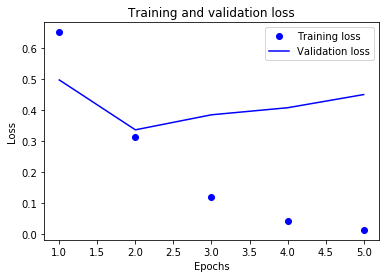

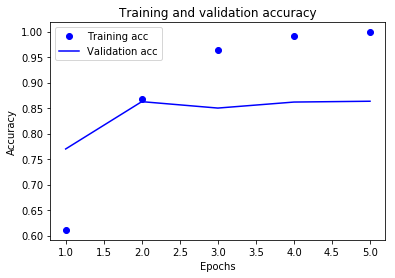

In [30]:
printLossAndAccuracy(history)

### Execise
We have a method that will predict a star rating for given review. A really positive review will be predicted as 5 Stars, whereas a really negative review will be predicted as 1 Star.

Try some sample reviews by changing the value of _my_review_ and see if the predicted Star rating matches your expectations.

Given this system and the specific requirement to estimate a Star rating, what are the risks you should test for?

Work in your teams and:
- List out some of the risks you would want to test for
- Try out some of your ideas out and record any issues you find

In [31]:
# Try a review out
my_review = "ok directing but good casting."


print(my_review)
print("\nPredicted Star Rating (1-5 Stars) is {}".format(predictStarRating(my_review, 
                                                         model, word_index)))

ok directing but good casting.

Predicted Star Rating (1-5 Stars) is 4 Stars
